In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import lfilter
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import logistic, circmean, vonmises, circstd 
import random
import time
import os

import os 

os.chdir('/Users/miguel/Desktop/')
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

In [2]:
def connectivity(n, modes):
    """Creates a (``n`` x ``n``) connectivity matrix for the ring neural field model.

    :param int n: number of rate neurons/population.
    :param collections.Iterable[float] modes: amplitude of the modes of connectivity ordered from 0 to n_modes.
    :return: connectivity matrix.
    :rtype: np.ndarray
    """
    
    [i_n, j_n] = np.meshgrid(range(n), range(n))
    ij = (i_n - j_n) * (2.0 * np.pi / n)

    jphi = 0
    for k, mode in enumerate(modes):
        if k == 0:
            jphi = mode
        else:
            jphi += 2.0 * mode * np.cos(k * ij)

    return jphi 

In [3]:
# Transfer function (scalar)

def sigmoid_pw(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, scalar version.

    :param float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: float
    """
    
    if isinstance(x, (list, np.ndarray)):
        return sigmoid_pw_v(x, a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    if x <= 0.0:
        return a * gamma / tau
    elif 0.0 < x < 1.0:
        return (a + x ** 2.0) * gamma / tau
    else:
        return (a + 2.0 * np.sqrt(x - 3.0 / 4.0)) * gamma / tau

In [4]:
# Transfer function (vectorial)

def sigmoid_pw_v(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, vectorial version.
    
    :param np.ndarray of float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: np.ndarray of float
    """
    
    if not isinstance(x, (list, np.ndarray)):
        return sigmoid_pw(float(x), a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    phi = x * 1.0
    # Conditions:
    m1 = (x <= 0.0)
    m3 = (x >= 1.0)
    m2 = ~(m1 | m3)
    # Function
    phi[m1] = a
    phi[m2] = a + x[m2] ** 2
    phi[m3] = a + 2.0 * np.sqrt(x[m3] - 3.0 / 4.0)

    return phi * gamma / tau 

In [5]:
def ou_process(dt, nsteps, mu, sigma, tau, trials=1, n_spatial=1, seed=None):
    """ Generates an approximation of a single (or trials) Ornstein-Uhlenbeck process(es)
        for a single (oumodes) units.

    :param float dt: integration time-step.
    :param int nsteps: number of time steps.
    :param float mu: offset of the processs.
    :param float sigma: standard deviation of the process.
    :param float tau: time scale of the process (< dt).
    :param int trials: number of processes to be generated (trials).
    :param int n_spatial: number of spatially distributed units or modes of Fourier.
    :param int or None seed: seed for the random number generator.
    :return: time series: array (nsteps x trials x oumodes).
    :rtype: np.ndarray
    """
    
    # Constants
    a = np.exp(-dt / tau)
    b = mu * (1.0 - a)
    c = sigma * np.sqrt(1.0 - a ** 2)

    if seed is not None:
        np.random.seed(seed)

    s = lfilter(np.ones(1), [1, -a], b + c * np.random.randn(nsteps, trials, n_spatial), axis=0)
    
    return s

In [6]:
def compute_phase(x, n, c=(0.0,), s=(0.0,), wavenumber=1):
    """ Function that gives an approximate value of the phase of a spatial profile by projecting the vector x
    into a cosine function.

    :param Cython.Includes.numpy.ndarray x: firing rates matrix (or vector) with shape (d1, d2, ..., n).
    :param int n: spatial dimension (spatial discretization).
    :param np.ndarray of float c: cosine function, precompute it for faster computation.
    :param np.ndarray of float s: sine function, precompute it for faster computation.
    :param int wavenumber: wavenumber of the corresponding phase that we want to compute.
    :rtype: np.ndarray of float
    """

    # Check external cosine and sine functions
    if len(c) != n or len(s) != n:
        c = np.cos(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)
        s = np.sin(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)

    # norm of sine and cosine functions depends on n (discretization of the space)
    return np.arctan2((np.dot(x, s) / (n / 2.0) ** 2), (np.dot(x, c) / (n / 2.0) ** 2))

In [7]:
def equalbins(x, nbins):
    """ Computes the binning vector of a given data vector `x` categorized in equal proportion in `nbins`.

    :param np.ndarray x: vector of data to be binned.
    :param int nbins: number of bins.
    :return: a vector with the bins corresponding to each data point.
    :rtype: np.ndarray
    """
    
    quantiles = np.quantile(x, np.arange(1, nbins) / nbins)
    edges = np.concatenate(([-np.inf], quantiles, [np.inf]))
    
    return np.digitize(x, edges)

In [8]:
def compute_estimation(dataframe, nbins=41, xlabel='theta', ylabel='theta_est', **kwargs):
    """ Computes the estimation curve given an angular binning with `nbins` bins.
    
    :param pd.DataFrame dataframe: data-frame containing the circular mean of the stimulus orientation along with
                                   its estimation by the model.
    :param int nbins: number of bins to divide the angular range and perform the average across trials.
    :param str ylabel: label of the outcome column in the data-frame.
    :param kwargs: additional keyword arguments.
    :return: Returns a tuple (binning: average stimulus orientation, average estimation, standard error).
    :rtype: (pd.Series, pd.Series, pd.Series)
    """
    
    lim = kwargs.pop('lim', np.pi/2)
    # We define the categories for the data points and the model points/line
    dataframe['bin'] = equalbins(dataframe[xlabel], nbins)
    # Group the data by the binning and compute the circular mean of the stimulus orientation averages and the 
    # circular mean of the estimated average orientations
    gby_bin = dataframe.groupby('bin')
    x_avg = gby_bin[xlabel].apply(circmean, low=-np.pi, high=np.pi)
    y_avg = gby_bin[ylabel].apply(circmean, low=-np.pi, high=np.pi)
    y_std = gby_bin[ylabel].apply(circstd, low=-np.pi, high=np.pi)
    # Select the data inside the desired range
    s_x = x_avg.loc[np.abs(x_avg) <= lim]
    s_y = y_avg.loc[np.abs(x_avg) <= lim]
    s_e = y_std.loc[np.abs(x_avg) <= lim]
    return s_x, s_y, s_e

### Single trial

In [9]:
start = time.time()
# Define some variables

tstim = 1.250
nstim = 4
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring network
ntrials = 1

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)

r = np.ones((rsteps, n)) * 0.1
phase = np.zeros(rsteps)

exc_drive = 0.05
i0 = 1 + exc_drive # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)
i1 = 7.5E-3
i2 = 25E-3

theta_stim = np.array([0, 10, -30, 20]) * np.pi / 180 # angular direction of the stimulus (set of 8 Gabor patches)
gabor_patch = i1 * np.cos(1 * (np.repeat(theta[np.newaxis,:], nstim, axis=0) - theta_stim[:, np.newaxis]))

modes = [-2.0, 1., .5]
cnt = connectivity(n, modes)

mu, sigmaou, tau_ou = 0, 0.075, 1E-3
ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n), seed=None

# Loop
tstep = 0    
temps = 0.0
ttau = dt / tau

while temps < tmax:   
    i_stim = gabor_patch[np.floor(temps / (tmax / nstim)).astype(int)]

    # Time step variables
    kp = tstep % rsteps #kp is the 0 step
    k = (tstep + rsteps - 1) % rsteps #k is the -1 step

    # 2. Presynaptic inputs
    s = 1.0 / n * np.dot(r[k], cnt)

    #3. Integration
    try:
        r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
        phase[kp] = compute_phase(r[kp], n)
    except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
        r[r < 1E-12] = 0.0
    
    tstep += 1
    temps = tstep * dt

# binary choice trials or no-choice trial
dec_mode = 0
if dec_mode == 1:    

    # Reset some variables
    tbias = .500
    tpoints_bias = np.arange(0, tbias, dt)
    rsteps_bias = len(tpoints_bias)

    r = np.concatenate((r, np.ones((rsteps_bias, n)) * 0.1))
    phase = np.concatenate((phase, np.zeros(rsteps_bias)))

    tstep = 0    
    temps = 0.0

    i_stim = i2 * np.cos(180/90 * (theta - np.pi/180 * 90))
    ou = ou_process(dt, rsteps_bias, mu, sigmaou, tau_ou, ntrials, n) # (stim_steps, ntrials, n) seed=None

    while temps < tbias:
            
        # Time step variables
        kp = tstep % rsteps_bias + rsteps #kp is the 0 step
        k = (tstep + rsteps_bias - 1) % (rsteps_bias - 1) + (rsteps - 1) #k is the -1 step

        # 2. Presynaptic inputs
        s = 1.0 / n * np.dot(r[k], cnt)

        # 3. Integration
        try:
            r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp - rsteps], tau=tau)) 
            phase[kp] = compute_phase(r[kp], n)
        except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
            r[r < 1E-12] = 0.0

        tstep += 1
        temps = tstep * dt
    
end = time.time()
print("Real stimulus direction:", theta_stim * 180 / np.pi % 360)
print("Phase of the bump:", phase * 180 / np.pi % 360)
print("Time elapsed:", end - start)

Real stimulus direction: [  0.  10. 330.  20.]
Phase of the bump: [326.18654376 277.74679416 238.75708825 ...   8.39776939   8.40659045
   8.40239207]
Time elapsed: 2.548328161239624


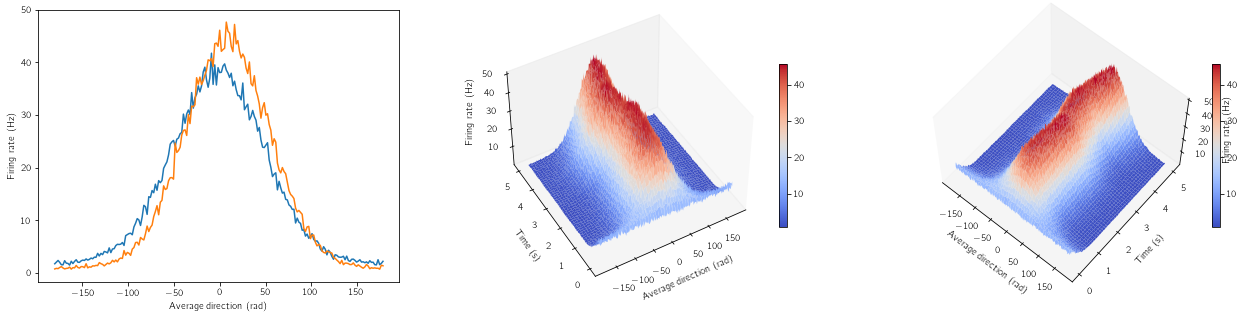

In [10]:
fig = plt.figure(figsize=(22, 5))
fig.tight_layout(pad=3.0)

ax1 = fig.add_subplot(131)
a = rsteps / 2
for i in [3750, -2]:
    ax1.plot(theta * 180/np.pi, r[i])
ax1.set_xlabel('Average direction (rad)')
ax1.set_ylabel('Firing rate (Hz)')

x = theta * 180 / np.pi
if dec_mode == 0:
    y = tpoints[50:-1]
if dec_mode == 1:
    y = np.concatenate((tpoints, tpoints_bias + tpoints[-1]))[50:-1]
X,Y = np.meshgrid(x,y)
Z = r[50:-1]

ax2 = fig.add_subplot(132, projection='3d')
surf1 = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax2.plot

ax2.view_init(45, 240)
ax2.set_xlabel('Average direction (rad)')
ax2.set_ylabel('Time (s)')
ax2.zaxis.set_label_coords(40, -10)
ax2.zaxis.set_rotate_label(False) 
ax2.set_zlabel('Firing rate (Hz)', rotation=90)
ax2.grid(False)

fig.colorbar(surf1, ax=ax2, shrink=0.6, aspect=20)

ax3 = fig.add_subplot(133, projection='3d')
surf1 = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax3.plot

ax3.view_init(60, 310)
ax3.set_xlabel('Average direction (rad)')
ax3.set_ylabel('Time (s)')
ax3.zaxis.set_label_coords(40, -10)
ax3.zaxis.set_rotate_label(False) 
ax3.set_zlabel('Firing rate (Hz)', rotation=90)
ax3.grid(False)

fig.colorbar(surf1, ax=ax3, shrink=0.6, aspect=20)

plt.show() 

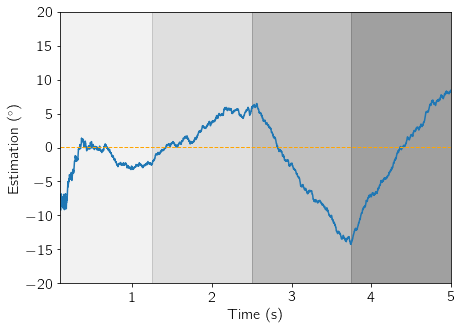

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1.plot(tpoints[500:], compute_phase(r[500:], n=200) * 180 / np.pi)
ax1.plot(tpoints[500:], np.repeat(0, tpoints[500:].shape), '--', lw=1, c='orange')

ax1.axvspan(0., 1.25, alpha=0.1, color='grey', zorder=1)
ax1.axvspan(1.25, 2.5, alpha=0.25, color='grey', zorder=1)
ax1.axvspan(2.5, 3.75, alpha=0.5, color='grey', zorder=1)
ax1.axvspan(3.75, 5, alpha=0.75, color='grey', zorder=1)

ax1.set_ylabel('Estimation $(^\circ)$', fontsize=15)
ax1.set_xlabel('Time (s)', fontsize=15)
ax1.set_ylim(-20, 20)
ax1.set_xlim(tpoints[450], 5)
ax1.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('/Users/miguel/Desktop/phase.pdf')
plt.show()

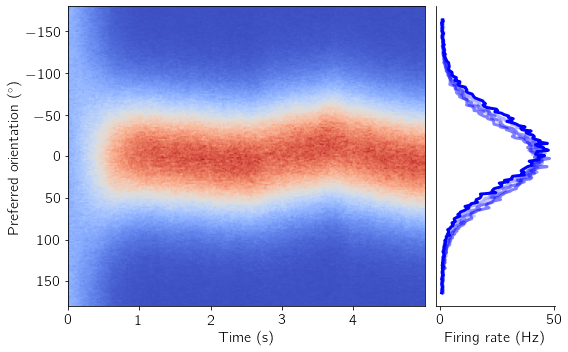

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [3, 1]})

ax1.set_xlim(0, tpoints[-1])
ax1.imshow(r.T, aspect='auto', cmap=cm.coolwarm, extent=[0, tpoints[-1], 180, -180])
ax1.margins(0, 0)
ax1.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_xlabel('Time (s)', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)


#surf = ax1.imshow(r.T, aspect='auto', cmap=cm.coolwarm)
#fig.colorbar(surf, ax=ax1, shrink=1, aspect=20, location='left')

#ax1.tick_params(labelbottom=False, bottom=False)

ax2.plot(r[5000], theta * 180/np.pi, c='blue', alpha=0.2, lw=3)
ax2.plot(r[10000], theta * 180/np.pi, c='blue', alpha=0.3, lw=3)
ax2.plot(r[15000], theta * 180/np.pi, c='blue', alpha=0.4, lw=3)
ax2.plot(r[20000], theta * 180/np.pi, c='blue', alpha=0.5, lw=3)
ax2.plot(r[-1], theta * 180/np.pi, c='blue', alpha=1, lw=3)

ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(axis='both', which='both')
ax2.tick_params(labelleft=False, left=False)
ax2.set_xlabel('Firing rate (Hz)', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/bumptrack.pdf')
plt.show()